In [1]:
%load_ext autoreload
%autoreload 2

# Q1 - Data preparation

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/thomasfoster/Documents/aims/dei/AIMS DEI/sotonmet.txt', index_col='Reading Date and Time (ISO)')

/Users/thomasfoster/Documents/aims/dei/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# normalise t to be minutes and start at 0
t = df.index
t = pd.to_datetime(t)
df.index = t

t0 = t[0]
t = t - t0
t = t.total_seconds() / 60
df.index = t

In [4]:
# extract training data
df_d = df['Tide height (m)'].dropna()
x_d = df_d.index
y_d = df_d.values

x_star = df[df['Tide height (m)'].isna()].index
y_star = df.loc[x_star]['True tide height (m)'].values


Text(0, 0.5, 'Tide height (m)')

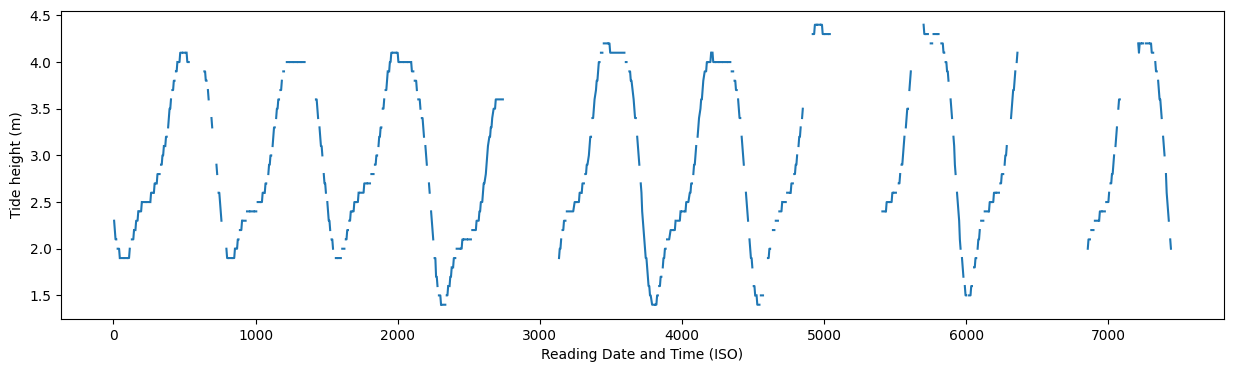

In [5]:
plt.figure(figsize=(15,4))
df['Tide height (m)'].plot()
plt.ylabel('Tide height (m)')

# Q2 - Use GP Utils to fit and predict with a GP

In [6]:
# Define a mean and covariance function
from kernels import get_matern_3_2

mu_func = lambda x : 3.0  # approx the mean of the data
k_func = get_matern_3_2(9.6, 1625)

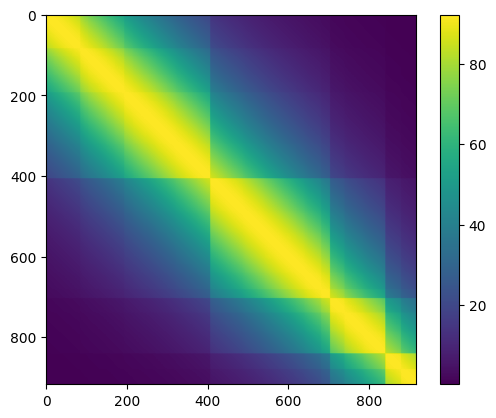

In [7]:
# Visualise the covariance function
k_vec = k_func(x_d, x_d)
plt.imshow(k_vec)
plt.colorbar()

In [8]:
# Fit the GP
from gp_utils import GP

mu, k, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.1, method='cholesky')

Constructing GP from 917 training points and 341 eval locations.


# Q3 - Numerically compare with the actual data

In [9]:
mse = np.mean((mu - y_star)**2)

from gp_utils import log_likelihood
nll = -log_likelihood(mu, k, y_star, sigma_squared=1e-8)

print(f"logp: {-log_p} and MSE: {mse:.2f} and NLL: {nll:.2f}")

logp: 1281.3341431692513 and MSE: 0.10 and NLL: 484.02


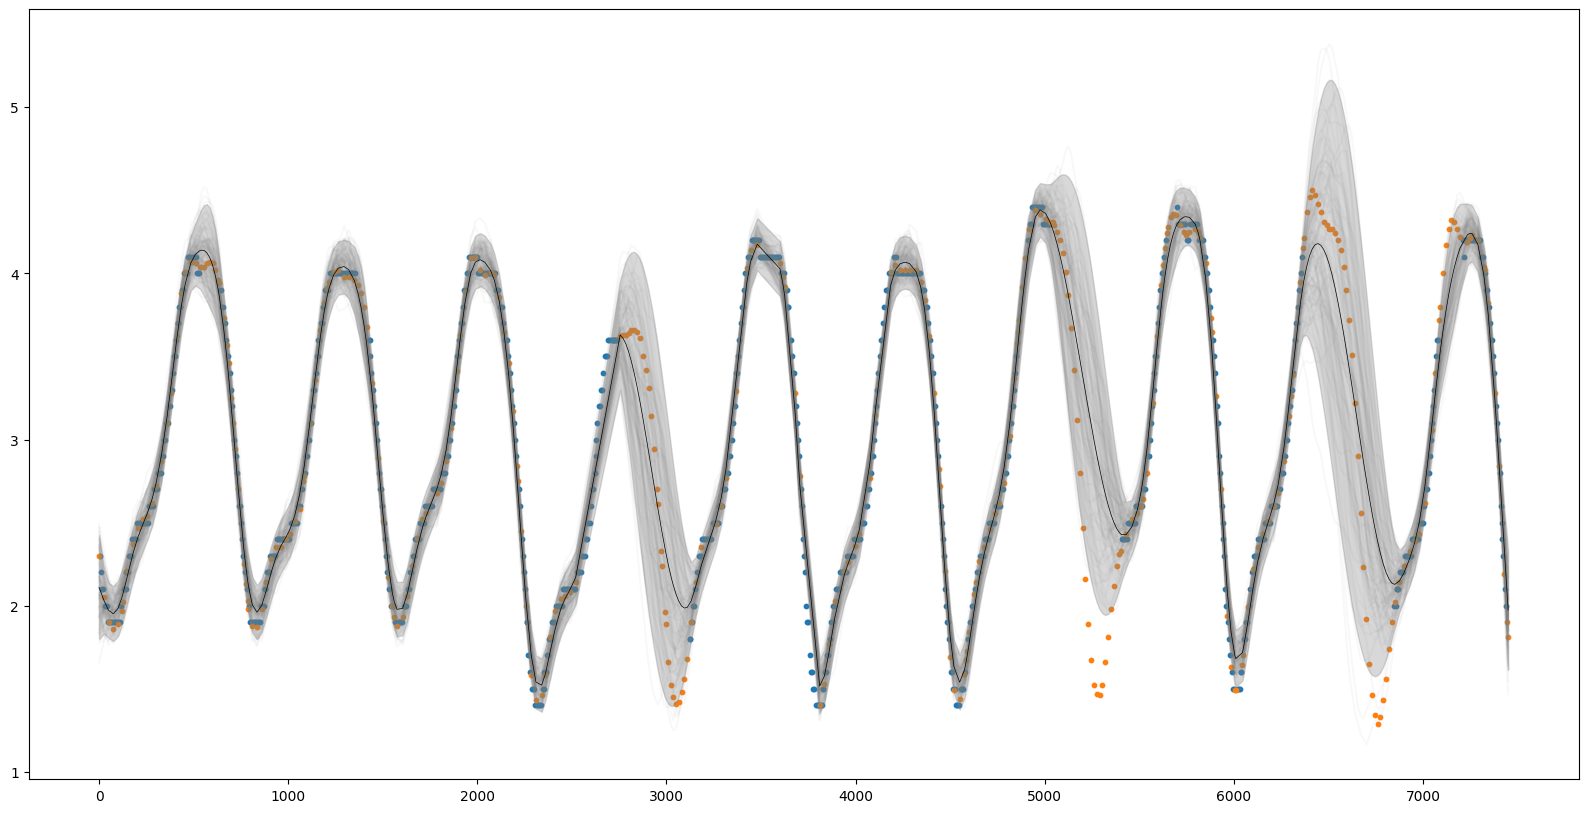

In [11]:
# Visualise the result

n_draws = 100

y_preds = np.random.multivariate_normal(
    mean=mu,
    cov=k,
    size=n_draws
)

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

for i in range(n_draws):
    plt.plot(x_star, y_preds[i], color='gray', alpha=0.05) # marker='x', markersize=10, 

plt.plot(x_star, mu, color='black', linewidth=0.5)

plt.scatter(x_d, y_d, s=10)
plt.scatter(x_star, y_star, s=10)

std = np.sqrt(np.diag(k))
plt.fill_between(x_star, mu - 2 * std, mu + 2 * std, alpha=0.3, color='gray')

# How much conditioning noise?

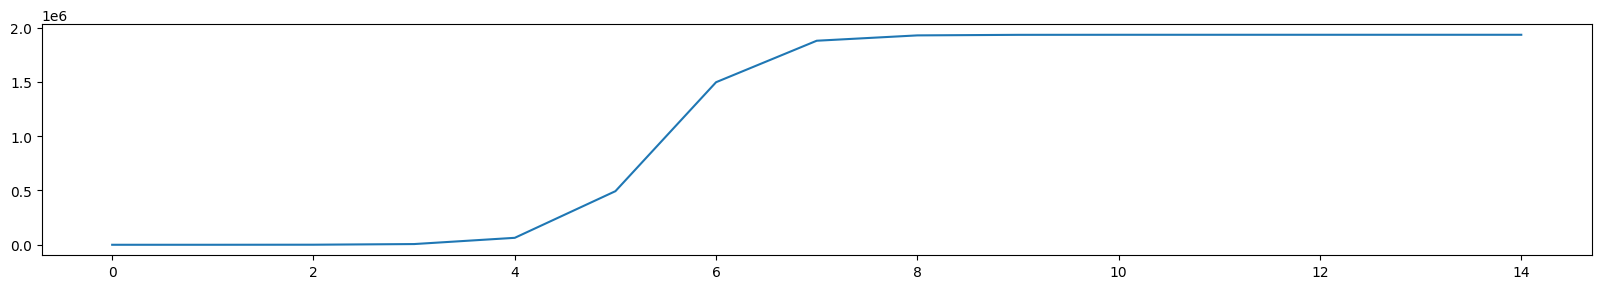

In [12]:
# We need to add a small amount of noise when computing the log likelihood
# This graph shows how little we can add before the conditioning error blows up
conds = [np.linalg.cond(k + 10**(-i) * np.eye(k.shape[0])) for i in range(15)]
plt.figure(figsize=(20,3))
plt.plot(conds)

# Q5 - Tuning Hyperparameters with grid search

In [214]:
# Do a simple grid search 
from tqdm.auto import tqdm

lambdas = [1, 2, 3, 4]
omegas = [10,50,100,150,200]

log_probs = np.empty((len(lambdas), len(omegas)))
mses = np.empty((len(lambdas), len(omegas)))
nlls = np.empty((len(lambdas), len(omegas)))

pbar = tqdm(total=len(lambdas)*len(omegas))

for i, l in enumerate(lambdas):
    for j, omega in enumerate(omegas):
        k_func = get_exponentiated_quadratic(l, omega)
        mu, cov, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.1, method='cholesky', verbose=False)
        mse = np.mean((mu - y_star)**2)
        nll = -log_likelihood(mu, cov, y_star, sigma_squared=1e-8)
        
        log_probs[i, j] = -log_p
        mses[i, j] = mse
        nlls[i, j] = nll
        
        pbar.update(1)

pbar.close()

100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


Best params for -log p(D|theta) at lambda: 1 and omega: 100
Best params for MSE(y_true,mu) at lambda: 2 and omega: 100
Best params for -log p(y_true|D, theta) at lambda: 1 and omega: 10


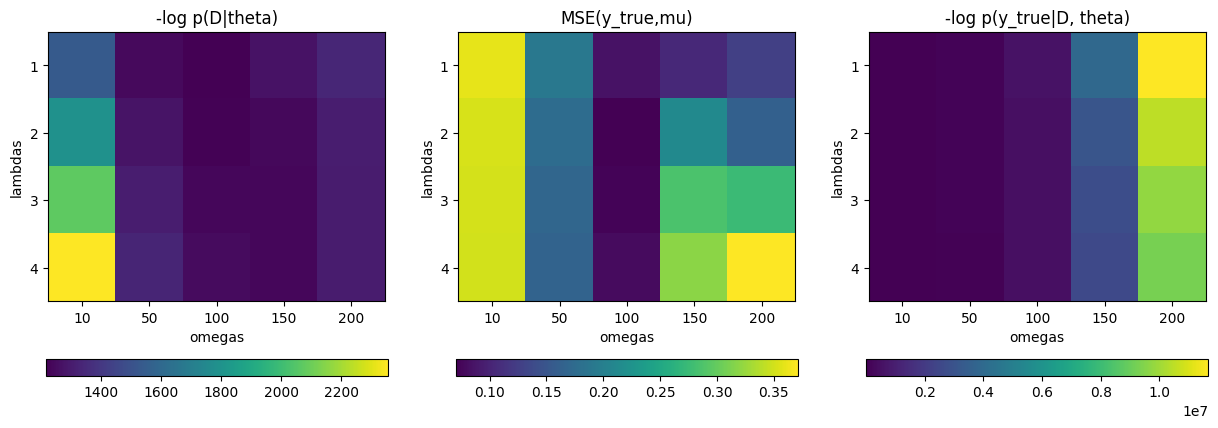

In [216]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(15)
fig.set_figheight(5)

titles = ['-log p(D|theta)', 'MSE(y_true,mu)', '-log p(y_true|D, theta)']
vals = [log_probs, mses, nlls]

for i in range(3):
    ax = axes[i]
    im = ax.imshow(vals[i])
    ax.set_title(titles[i])
    ax.set_xlabel('omegas')
    ax.set_xticks(range(len(omegas)), omegas)
    ax.set_ylabel('lambdas')
    ax.set_yticks(range(len(lambdas)), lambdas)
    fig.colorbar(im, ax=ax, orientation='horizontal')

    def smallestN_indices(a, N):
        idx = a.ravel().argsort()[:N]
        return np.stack(np.unravel_index(idx, a.shape)).T
    
    l_star, omega_star = smallestN_indices(vals[i], 1).flatten()
    
    print(f"Best params for {titles[i]} at lambda: {lambdas[l_star]} and omega: {omegas[omega_star]}")

# Q4 - Prediction with other kernels

In [20]:
# Define a mean and covariance function
from kernels import get_exponentiated_quadratic, get_rational_quadratic, get_matern_3_2, get_periodic, get_affine, combine_add, combine_product

mu_func = lambda x : 3.0  # approx the mean of the data

k_funcs = {
    'periodic': get_periodic(5.6, 9641, 741),
    'matern': get_matern_3_2(9.6, 1625),
    'exp quadratic': get_exponentiated_quadratic(5.9, 103),
    # 'affine': get_affine(1.3, 1.3, 1.3),
    'periodic + matern': combine_add(
      get_periodic(9.7, 5482, 7994),
      get_matern_3_2(4.1, 1969),
    ),
    'period * rational quad': combine_product(
        get_periodic(0.14, 5479, 330),
        get_rational_quadratic(7.43, 41.0, 3.63),
    ),
    'period * radional quad + matern': combine_add(
      combine_product(
        get_periodic(9.08, 7729, 8468),
        get_rational_quadratic(0.95, 110, 0.7),
      ),
      get_matern_3_2(4.23, 7940)
    )
}

periodic
Constructing GP from 917 training points and 341 eval locations.
logp: 1719.1039147983206 and MSE: 0.11 and NLL: 1024720961.86


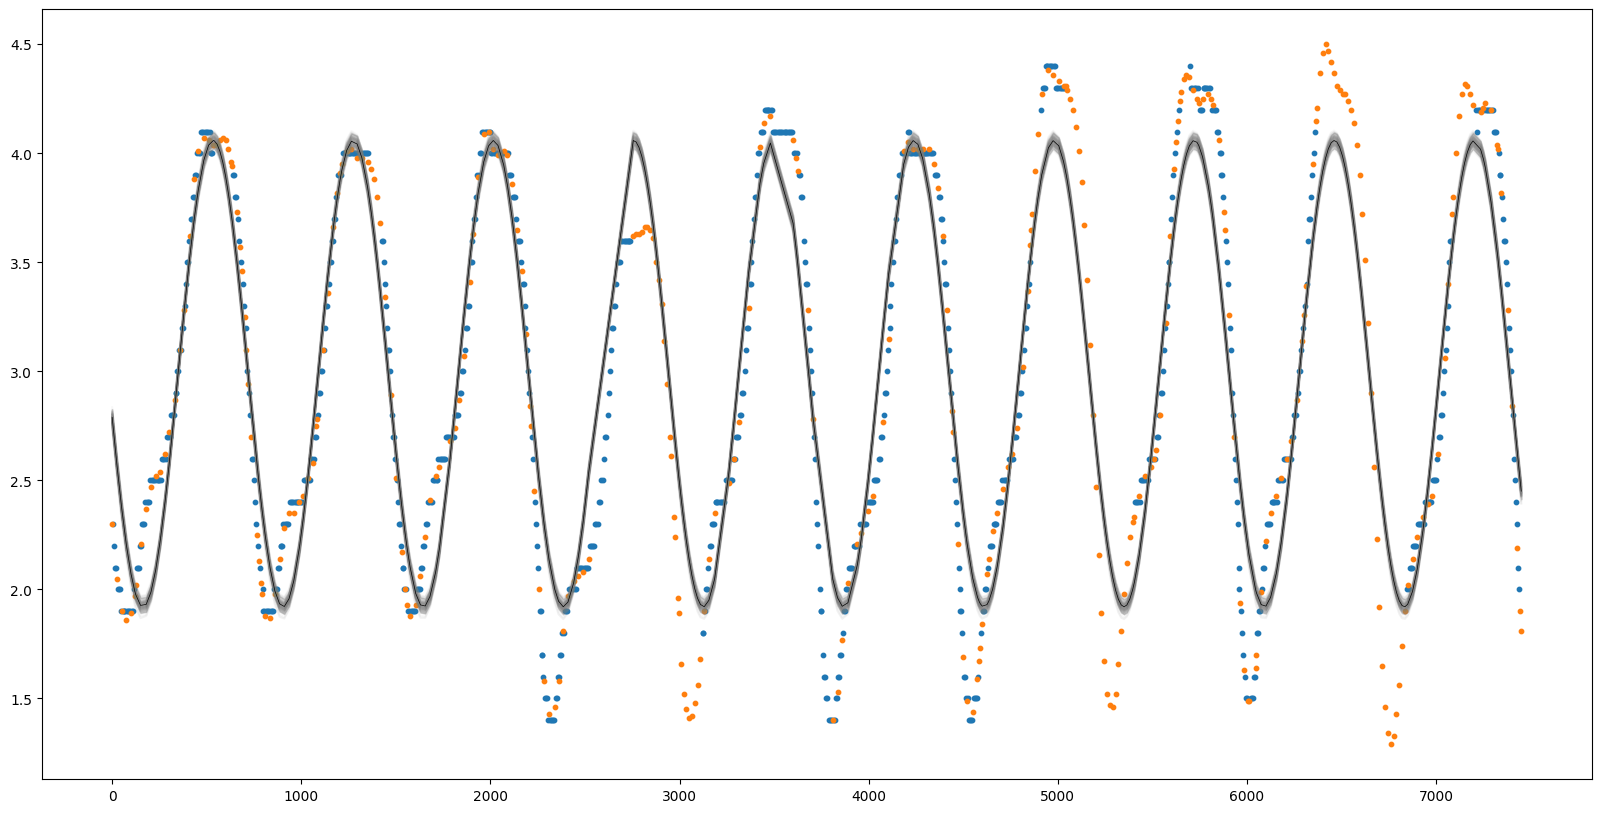

matern
Constructing GP from 917 training points and 341 eval locations.
logp: 1281.3341431692513 and MSE: 0.10 and NLL: 484.02


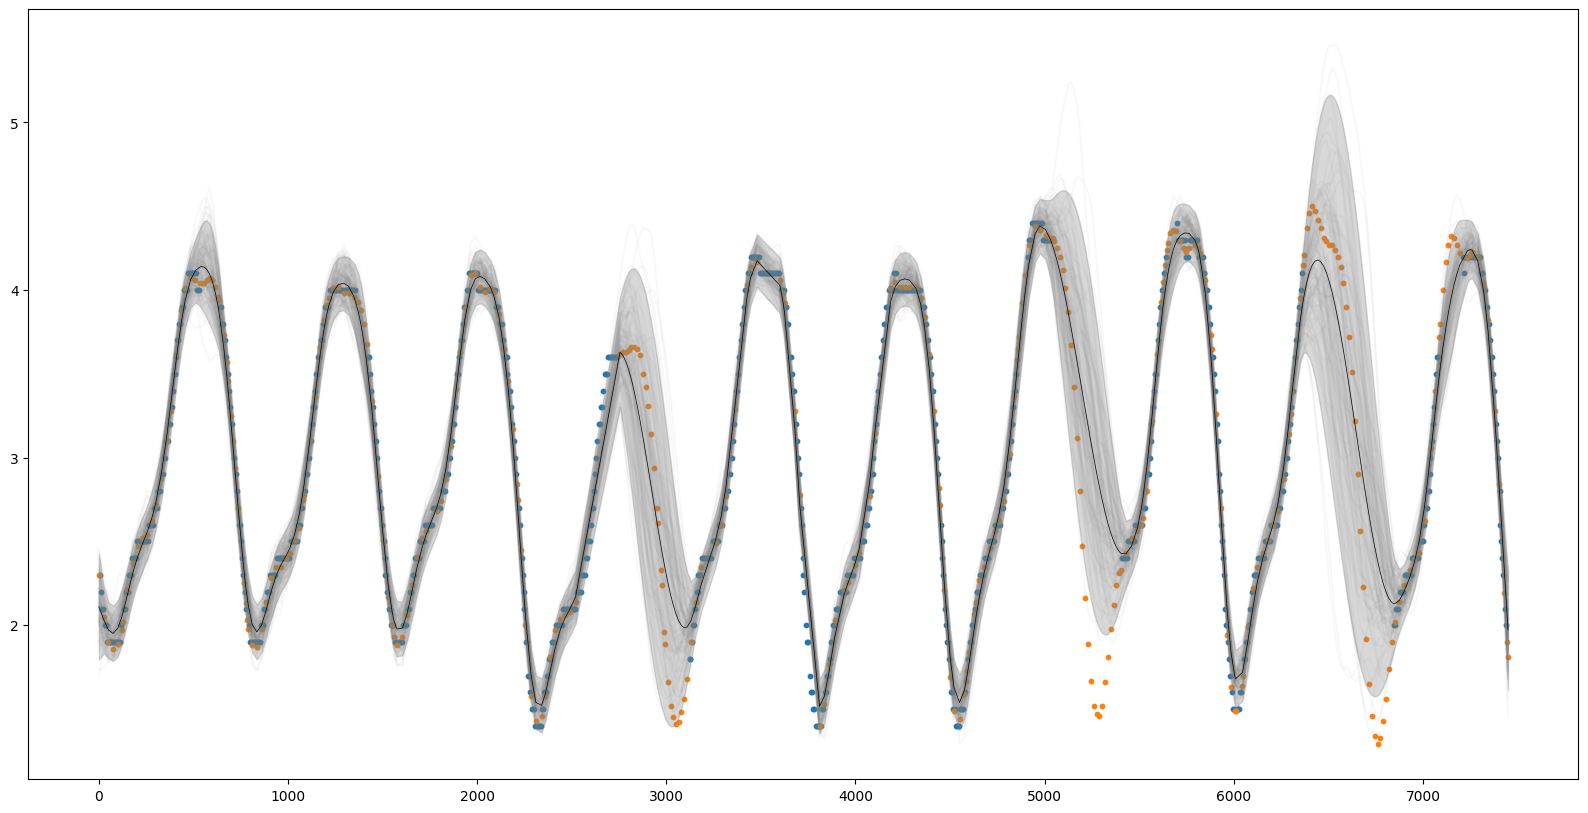

exp quadratic
Constructing GP from 917 training points and 341 eval locations.
logp: 1268.3162386272259 and MSE: 0.10 and NLL: 467424.64


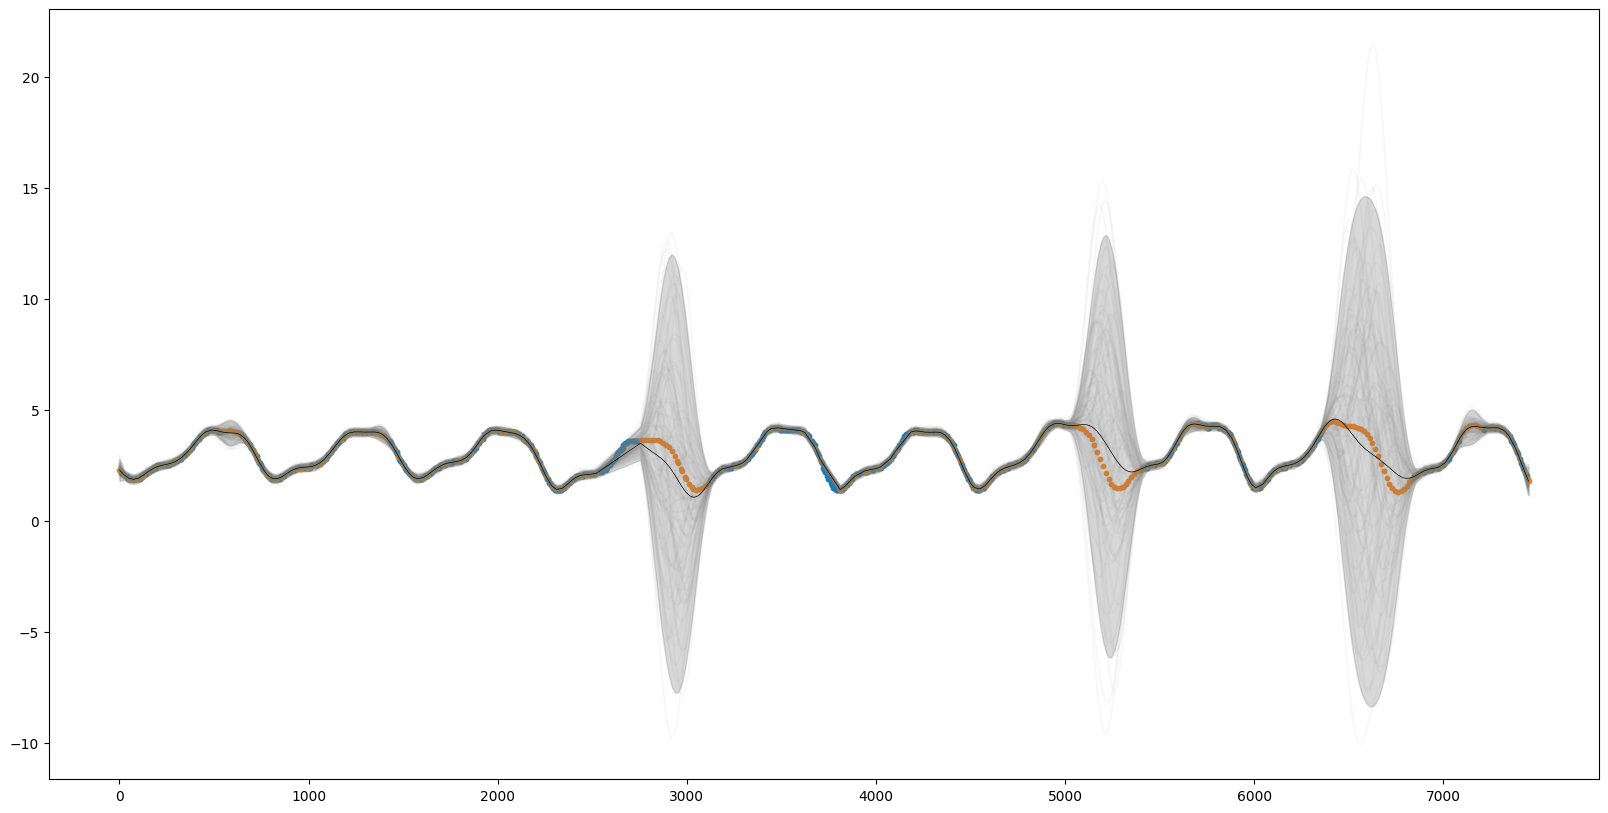

periodic + matern
Constructing GP from 917 training points and 341 eval locations.
logp: 1780.5053217673058 and MSE: 0.20 and NLL: 4443.87


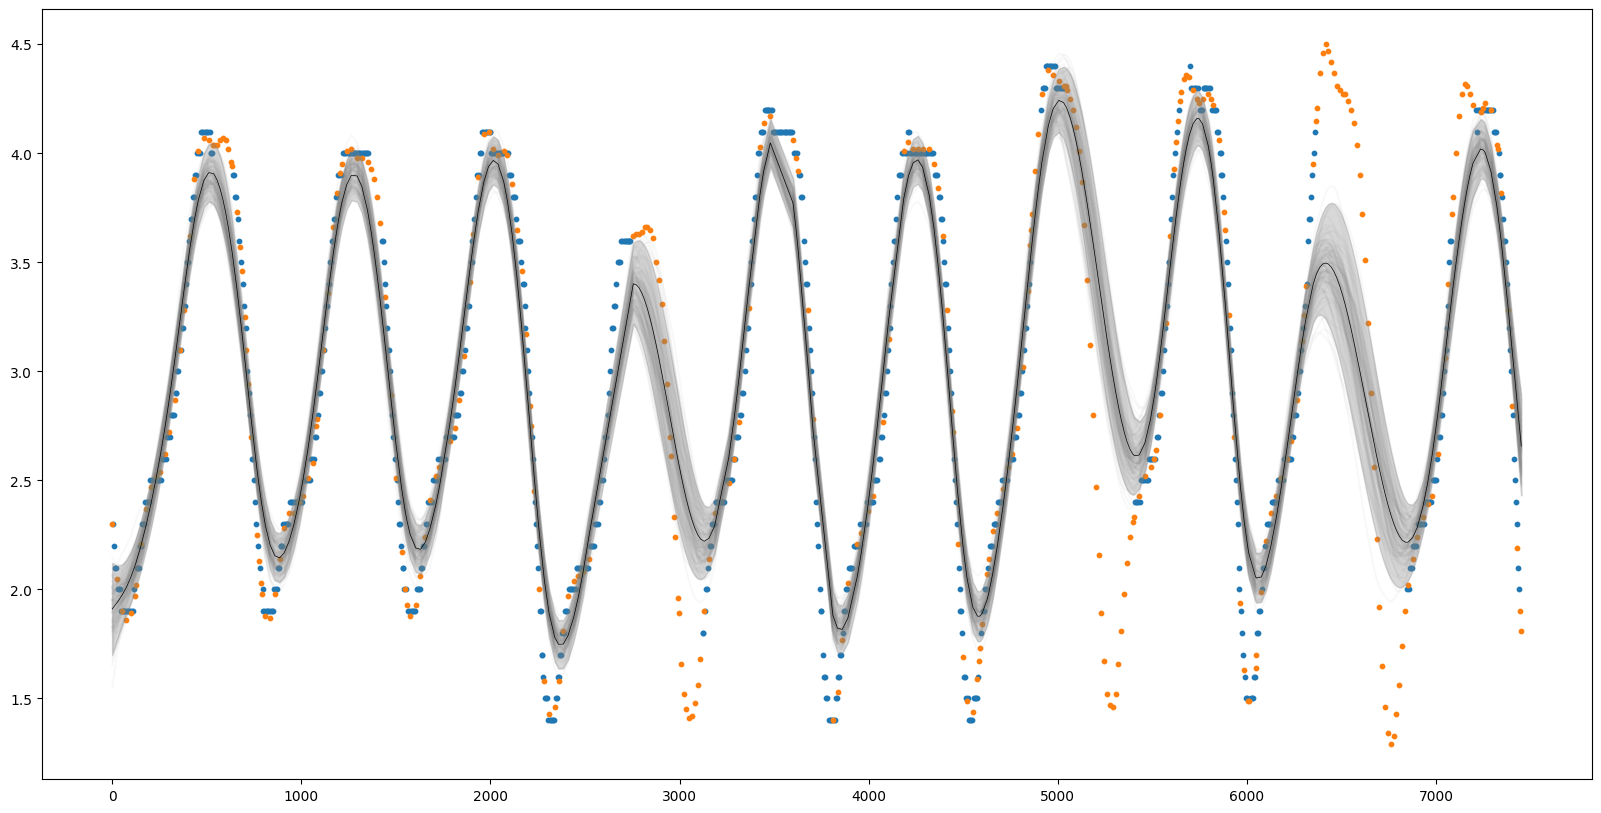

period * rational quad
Constructing GP from 917 training points and 341 eval locations.
logp: 1266.8470715436947 and MSE: 0.21 and NLL: 3491.25


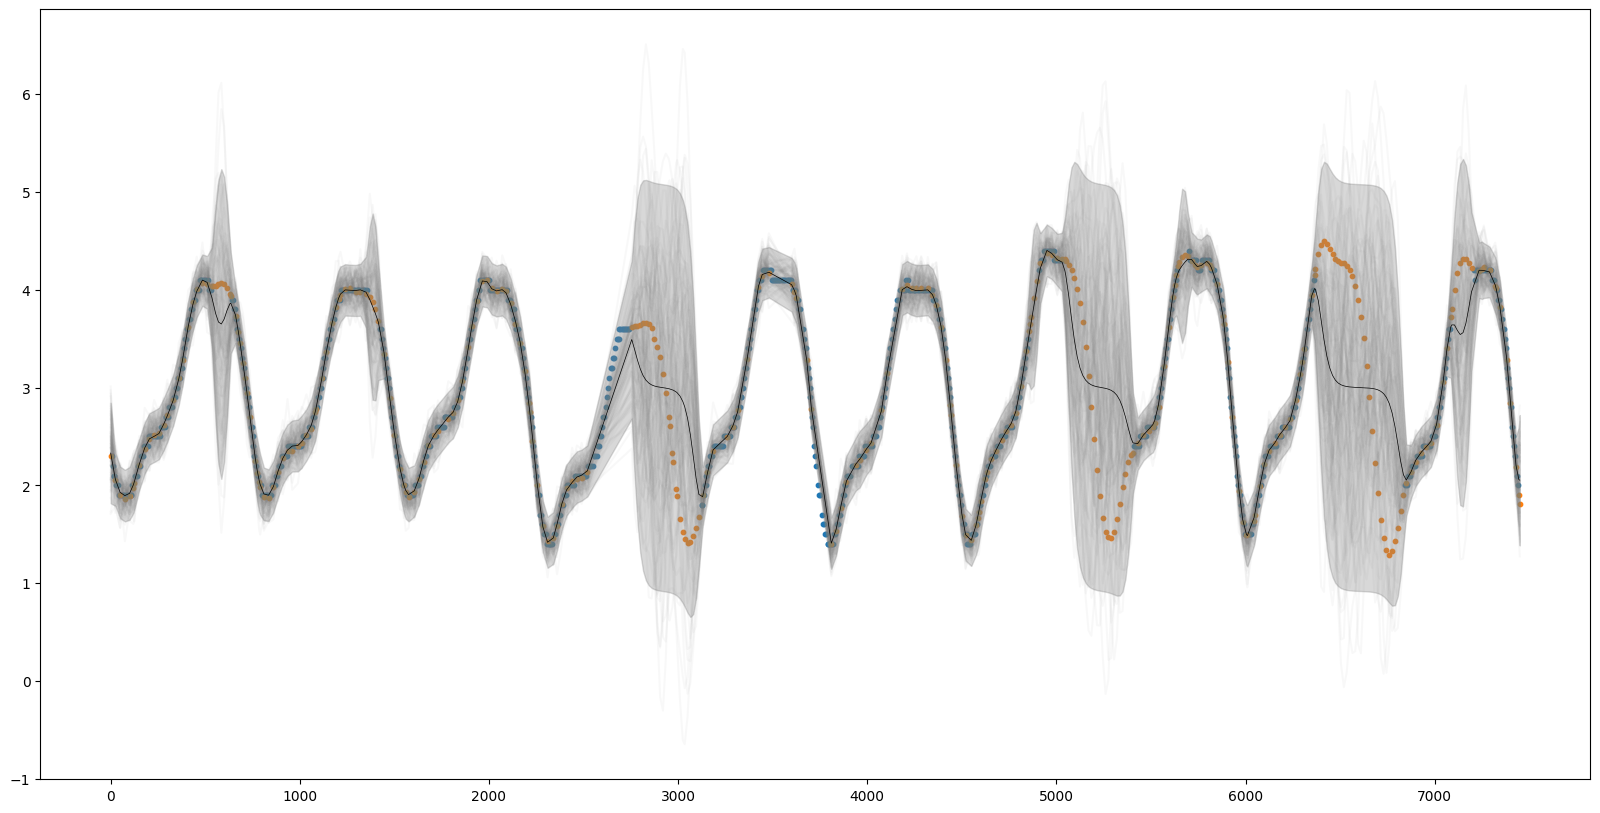

period * radional quad + matern
Constructing GP from 917 training points and 341 eval locations.
logp: 1308.2497859709424 and MSE: 0.09 and NLL: 12211.33


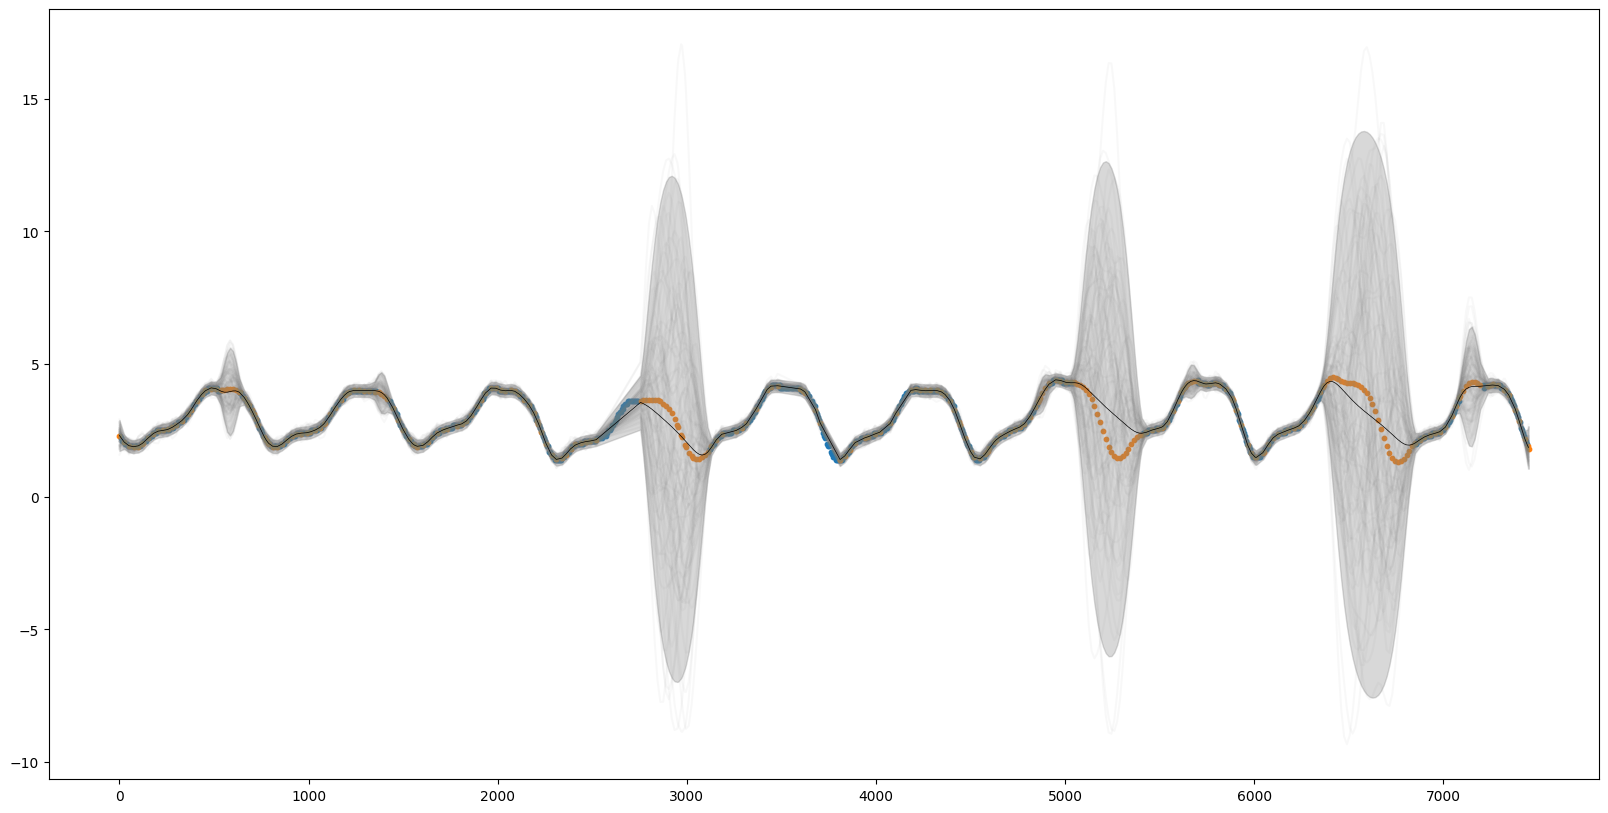

In [21]:
for k_func_name, k_func in k_funcs.items():

    print(k_func_name)
    
    mu, k, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.1, method='cholesky')

    mse = np.mean((mu - y_star)**2)
    nll = -log_likelihood(mu, k, y_star, sigma_squared=1e-8)
    print(f"logp: {-log_p} and MSE: {mse:.2f} and NLL: {nll:.2f}")

    n_draws = 100

    y_preds = np.random.multivariate_normal(
        mean=mu,
        cov=k,
        size=n_draws
    )

    import matplotlib.pyplot as plt

    plt.figure(figsize=(20,10))

    for i in range(n_draws):
        plt.plot(x_star, y_preds[i], color='gray', alpha=0.05) # marker='x', markersize=10, 

    plt.plot(x_star, mu, color='black', linewidth=0.5)

    plt.scatter(x_d, y_d, s=10)
    plt.scatter(x_star, y_star, s=10)

    std = np.sqrt(np.diag(k))
    plt.fill_between(x_star, mu - 2 * std, mu + 2 * std, alpha=0.3, color='gray')

    plt.show()
    

# Trying different kernels requires better hyperparam optimisation

In [56]:
# We have access to lots of kernels, but we'll need better hyperopt
from hyperopt import hp, fmin, tpe, Trials
import numpy as np

def add_noise(params):
   small_param = lambda k : k.startswith('l_') or k.startswith('alpha_')
   return {
      k: p + np.random.random() if small_param(k) else p + 10*np.random.random()
      for k,p in params.items()
   }

# Function to optimize    
def noisy_objective(params):
    params = add_noise(params)

    # Define covariance function    
    k_func = combine_add(
      combine_product(
        get_periodic(params['l_periodic'], params['omega_periodic'], params['p_periodic']),
        get_rational_quadratic(params['l_rq'], params['omega_rq'], params['alpha_rq']),
      ),
      get_matern_3_2(params['l_matern'], params['omega_matern'])
    )
    
    # compute GP
    mu, cov, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.01, method='cholesky', verbose=False)

    # calculate loss
    # mse = np.mean((mu - y_star)**2)
    # nll = -log_likelihood(mu, cov, y_star, sigma_squared=1e-5)

    return -log_p

# Take average of 3 replicates to reduce noise  
def objective(params):

  rep1 = noisy_objective(params)
  rep2 = noisy_objective(params)
  rep3 = noisy_objective(params)
  
  return (rep1 + rep2 + rep3) / 3

# Define hyperparameter space
space = {
    'l_periodic': hp.uniform('l_periodic', 0.1, 10),
    'l_rq': hp.uniform('l_rq', 0.1, 10),
    'l_matern': hp.uniform('l_matern', 0.1, 10),
    'omega_periodic': hp.uniform('omega_periodic', 0.1, 10_000),
    'omega_rq': hp.uniform('omega_rq', 0.1, 10_000),
    'omega_matern': hp.uniform('omega_matern', 0.1, 10_000),
    'p_periodic': hp.uniform('p_periodic', 0.1, 10_000),
    'alpha_rq': hp.uniform('alpha_rq', 0, 5)
}

# Optimization algorithm
algo = tpe.suggest 

# Trials object to track progress
trials = Trials()

# Run optimization
best = fmin(fn=objective, space=space, algo=algo, max_evals=30, trials=trials, show_progressbar=True)

print(best)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

job exception: get_rational_quadratic() missing 1 required positional argument: 'alpha'



  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]


TypeError: get_rational_quadratic() missing 1 required positional argument: 'alpha'

# Is using the cholesky worth it?

In [41]:
%timeit mu_sp, k_sp, log_p_sp = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.1, method='scipy_solve')
%timeit mu, k, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.1, method='cholesky')

Constructing GP from 917 training points and 341 eval locations.


/Users/thomasfoster/Documents/aims/dei/.venv/lib/python3.10/site-packages/numpy/lib/scimath.py:296: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)


Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
524 ms ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 917 training points and 341 eval locations.
Constructing GP from 91

# Q10 - Leveraging more data

We look at leveraging the air temperature as an auxillary predictive input.

In [44]:
df.columns

Index(['Update Duration (ms)', 'Air pressure (mb)', 'Air temperature (C)',
       'Tide height (m)', 'Wind direction (deg)', 'Wind gust speed (kn)',
       'Wind speed (kn)', 'True air temperature (C)', 'True tide height (m)',
       'Independent tide height prediction (m)',
       'Independent tide height deviation (m)',
       'Dependent tide height prediction (m)',
       'Dependent tide height deviation (m)',
       'Independent air temperature prediction (C)',
       'Independent air temperature deviation (C)',
       'Dependent air temperature prediction (C)',
       'Dependent air temperature deviation (C)'],
      dtype='object')

In [45]:
df.drop(columns=['Update Date and Time (ISO)'], inplace=True)

KeyError: "['Update Date and Time (ISO)'] not found in axis"

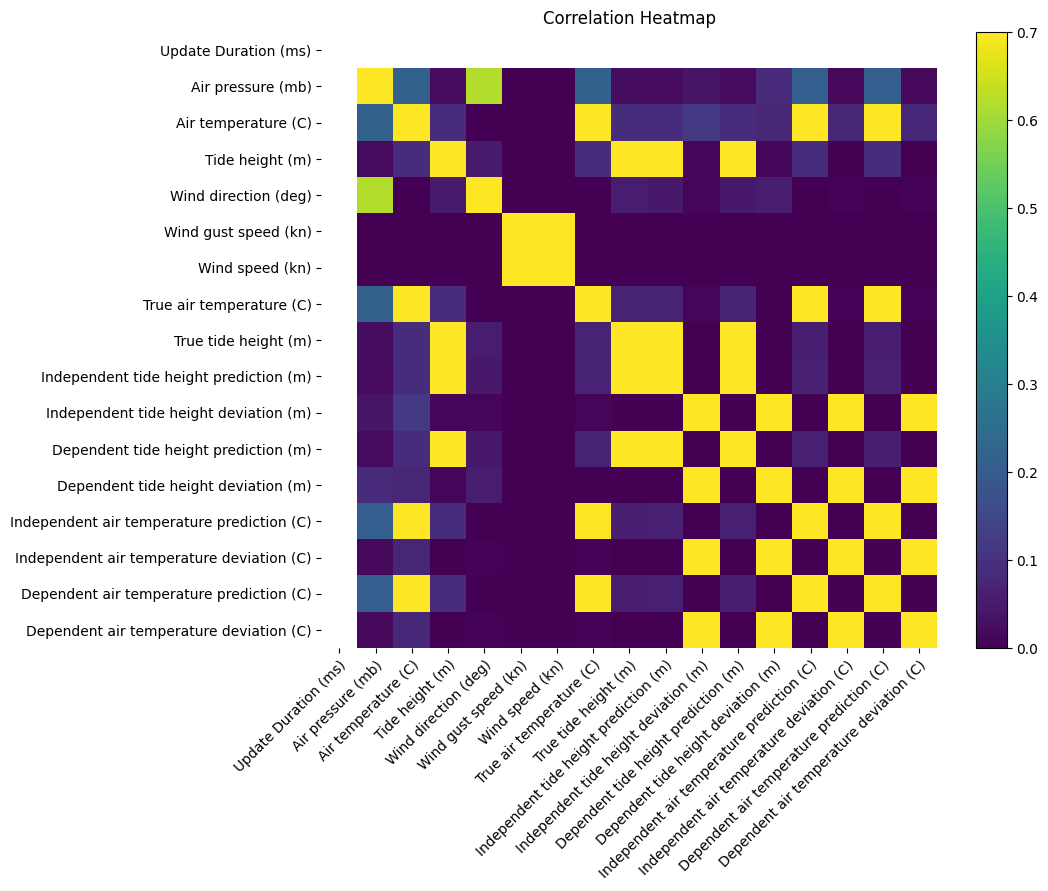

In [46]:
# Plot correlations to see what we can use to model tide height.

corr = df.corr().clip(0,0.7)

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(corr)

# Show column names 
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

# Rotate tick labels and set alignment  
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Turn spines off  
ax.spines[:].set_visible(False) 

# Other aesthetics
fig.colorbar(im)
plt.title('Correlation Heatmap')
plt.show()

In [47]:
# extract training data
df_d = df[~df['Tide height (m)'].isna()]
x_d_timestamps = df_d.index
x_d_airtemp = df_d['True air temperature (C)'].values
x_d = np.stack([x_d_timestamps, x_d_airtemp], axis=-1)
y_d = df_d['Tide height (m)'].values

df_star = df[df['Tide height (m)'].isna()]
x_star_timestamps = df_star.index
x_star_airtemp = df_star['True air temperature (C)'].values
x_star = np.stack([x_star_timestamps, x_star_airtemp], axis=-1)
y_star = df_star['True tide height (m)'].values

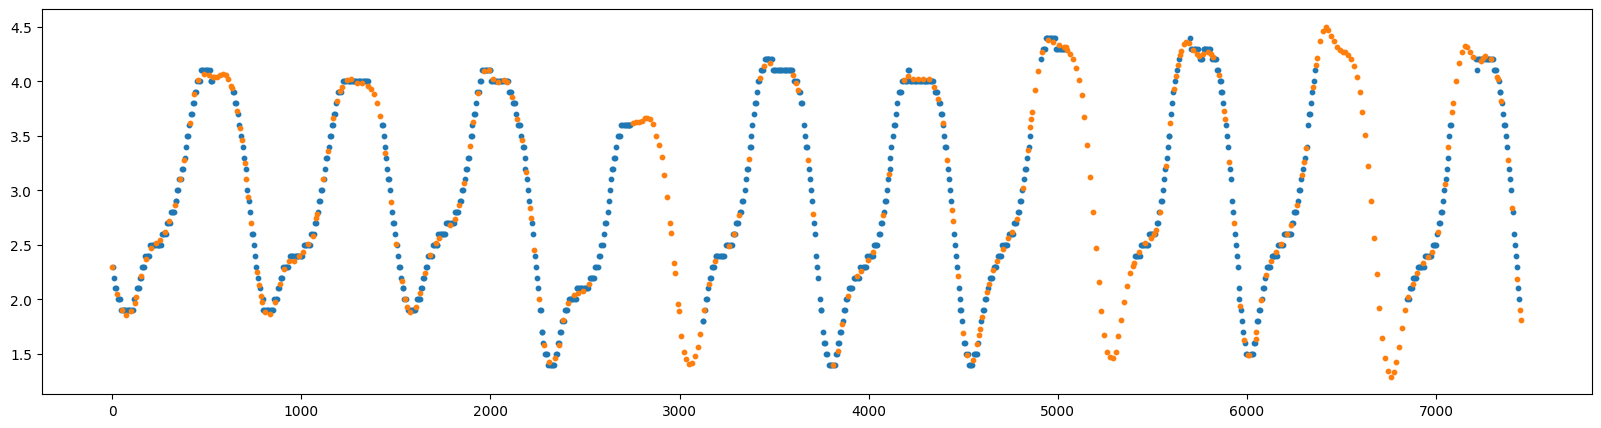

In [48]:
plt.figure(figsize=(20,5))
plt.scatter(x_d_timestamps, y_d, s=10)
plt.scatter(x_star_timestamps, y_star, s=10)

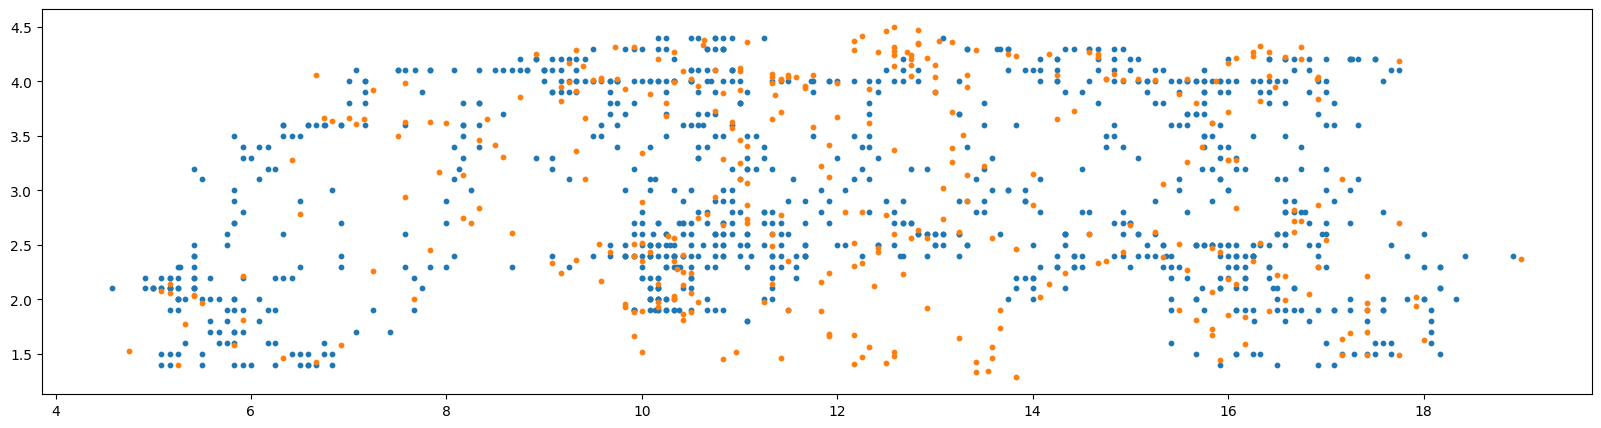

In [49]:
plt.figure(figsize=(20,5))
plt.scatter(x_d_airtemp, y_d, s=10)
plt.scatter(x_star_airtemp, y_star, s=10)

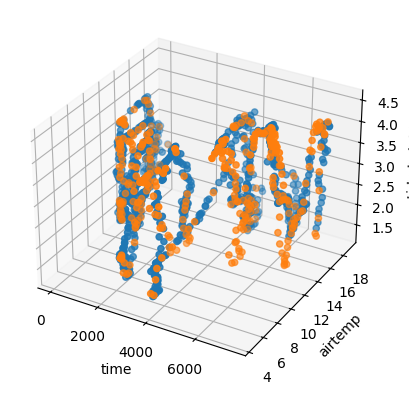

In [50]:
# Create figure and 3D axes
fig = plt.figure()
ax = plt.axes(projection='3d')

# Add scatter plot
ax.scatter3D(x_d_timestamps, x_d_airtemp, y_d)
ax.scatter3D(x_star_timestamps, x_star_airtemp, y_star)

# Label axes
ax.set_xlabel('time')
ax.set_ylabel('airtemp')
ax.set_zlabel('tide height') 

# Show plot
plt.show()

#### We use the product of two kernels acting independetly on each dimension.

In [51]:
# We first define a mean and covariance function
from kernels import get_exponentiated_quadratic, get_rational_quadratic, get_matern_3_2, get_periodic, get_affine, combine_add, combine_product
from gp_utils import GP

# Do a simple grid search 
from tqdm.auto import tqdm

omegas_timestamps = [10, 50, 100, 500, 1000]
omegas_aux = [5, 10, 50, 100, 500]

log_probs = np.empty((len(omegas_timestamps), len(omegas_aux)))
mses = np.empty((len(omegas_timestamps), len(omegas_aux)))
nlls = np.empty((len(omegas_timestamps), len(omegas_aux)))

pbar = tqdm(total=len(omegas_timestamps)*len(omegas_aux))

for i, omega_timestamp in enumerate(omegas_timestamps):
    for j, omega_aux in enumerate(omegas_aux):
        mu_func = lambda x : 3.0  # approx the mean of the data
        
        k_func = combine_product(
            get_exponentiated_quadratic(1.0, omega_timestamp, dims=0),
            get_exponentiated_quadratic(1.0, omega_aux, dims=1)
        )
        
        mu, cov, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.1, method='cholesky', verbose=False)
        
        mse = np.mean((mu - y_star)**2)
        nll = -log_likelihood(mu, cov, y_star, sigma_squared=1e-8)
        
        log_probs[i, j] = -log_p
        mses[i, j] = mse
        nlls[i, j] = nll
        
        pbar.update(1)

pbar.close()

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:41<00:00,  1.68s/it]


Best params for log probs at omega timestamps: 100 and omega aux: 500
Best params for mse at omega timestamps: 100 and omega aux: 10
Best params for nll at omega timestamps: 10 and omega aux: 500


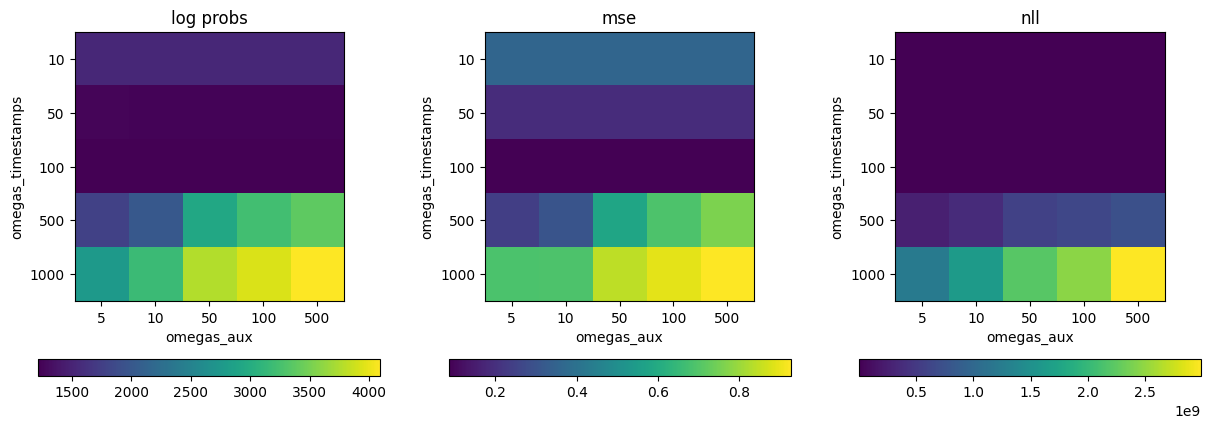

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(15)
fig.set_figheight(5)

titles = ['log probs', 'mse', 'nll']
vals = [log_probs, mses, nlls]

for i in range(3):
    ax = axes[i]
    im = ax.imshow(vals[i])
    ax.set_title(titles[i])
    ax.set_xlabel('omegas_aux')
    ax.set_xticks(range(len(omegas_aux)), omegas_aux)
    ax.set_ylabel('omegas_timestamps')
    ax.set_yticks(range(len(omegas_timestamps)), omegas_timestamps)
    fig.colorbar(im, ax=ax, orientation='horizontal')

    def smallestN_indices(a, N):
        idx = a.ravel().argsort()[:N]
        return np.stack(np.unravel_index(idx, a.shape)).T
    
    l_star, omega_star = smallestN_indices(vals[i], 1).flatten()
    
    print(f"Best params for {titles[i]} at omega timestamps: {omegas_timestamps[l_star]} and omega aux: {omegas_aux[omega_star]}")

In [55]:
mu_func = lambda x : 3.0  # approx the mean of the data
k_func = combine_product(
    get_exponentiated_quadratic(1.0, 100, dims=0),
    get_exponentiated_quadratic(1.0, 500, dims=1)
)
# k_func = get_exponentiated_quadratic(3.0, 10)
mu, k, log_p = GP(x_d, y_d, x_star, mu_func, k_func, sigma_squared=0.01, method='cholesky')

mse = np.mean((mu - y_star)**2)
nll = -log_likelihood(mu, k, y_star, sigma_squared=1e-8)
print(f"logp: {-log_p} and MSE: {mse:.2f} and NLL: {nll:.2f}")

Constructing GP from 917 training points and 341 eval locations.
logp: 1042.7774227110172 and MSE: 0.07 and NLL: 380253.66


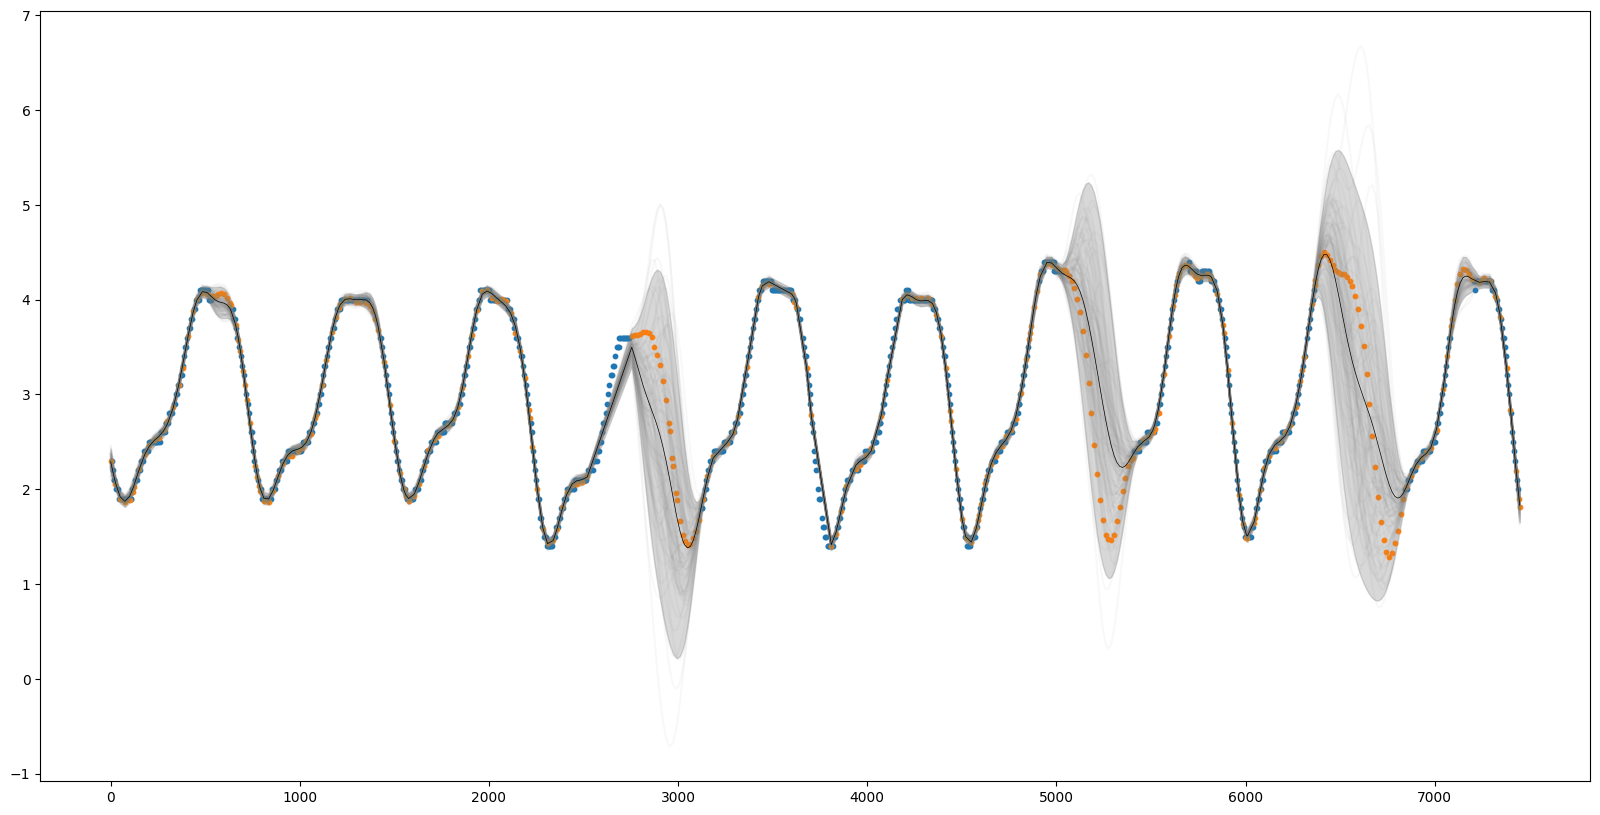

In [54]:
n_draws = 100

y_preds = np.random.multivariate_normal(
    mean=mu,
    cov=k,
    size=n_draws
)

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

for i in range(n_draws):
    plt.plot(x_star_timestamps, y_preds[i], color='gray', alpha=0.05) # marker='x', markersize=10, 

plt.plot(x_star_timestamps, mu, color='black', linewidth=0.5)

std = np.sqrt(np.diag(k))
plt.fill_between(x_star_timestamps, mu - 2 * std, mu + 2 * std, alpha=0.3, color='gray')

plt.scatter(x_d_timestamps, y_d, s=10)
plt.scatter(x_star_timestamps, y_star, s=10)